[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ourownstory/neural_prophet/blob/master/tutorials/feature-use/crossvalidation.ipynb)

# Test and CrossValidate

In [1]:
if 'google.colab' in str(get_ipython()):
    !pip install git+https://github.com/ourownstory/neural_prophet.git # may take a while
    #!pip install neuralprophet # much faster, but may not have the latest upgrades/bugfixes
    
import pandas as pd
from neuralprophet import NeuralProphet, set_log_level
set_log_level("ERROR")

## Load data

In [2]:
data_location = "https://raw.githubusercontent.com/ourownstory/neuralprophet-data/main/datasets/"
# df = pd.read_csv(data_location + "air_passengers.csv")

## 1. Basic: Train and Test a model
First, we show how to fit a model and evaluate it on a holdout set.

Note: before making any actual forecasts, re-fit the model on all data available, else you are greatly reducing your forecast accuracy!

### 1.1 Train-Test evaluation

In [3]:
m = NeuralProphet(seasonality_mode= "multiplicative", learning_rate = 0.1)

df = pd.read_csv(data_location + "air_passengers.csv")
df_train, df_test = m.split_df(df=df, freq="MS", valid_p=0.2)

metrics_train = m.fit(df=df_train, freq="MS")
metrics_test = m.test(df=df_test)

metrics_test

,SmoothL1Loss,MAE,RMSE
0,0.005541,27.541485,33.474789


### 1.2 Bonus: Predict into future
Before making any actual forecasts, re-fit the model on all data available, else you are greatly reducing your forecast accuracy!

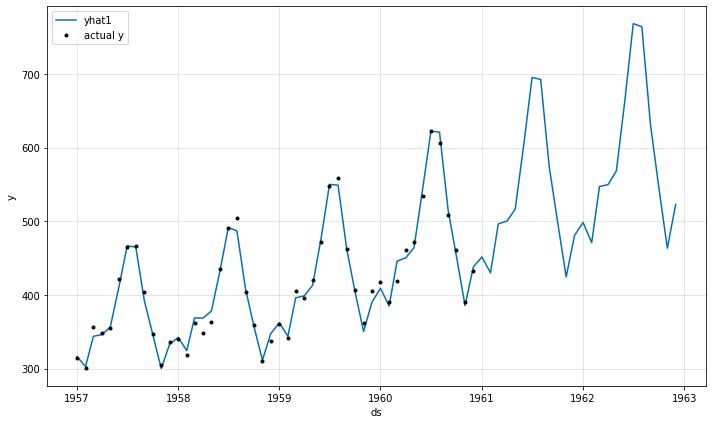

In [4]:
m = NeuralProphet(seasonality_mode= "multiplicative", learning_rate = 0.1)
metrics_train2 = m.fit(df=df, freq="MS")
future = m.make_future_dataframe(df, periods=24, n_historic_predictions=48)
forecast = m.predict(future)
fig = m.plot(forecast)
fig = m.plot(forecast, plotting_backend="plotly").show()

### 1.3 Bonus: Visualize training
If you installed the `[live]` version of NeuralProphet, you can additionally visualize your training progress and spot any overfitting by evaluating every epoch.

Note: Again, before making any predictions, re-fit the model with the entire data first.

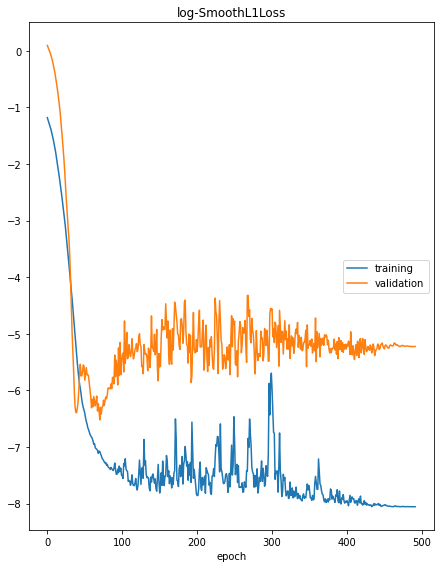

log-SmoothL1Loss
	training         	 (min:   -8.057, max:   -1.180, cur:   -8.056)
	validation       	 (min:   -6.522, max:    0.096, cur:   -5.225)


In [5]:
m = NeuralProphet(seasonality_mode="multiplicative", learning_rate=0.1)

df = pd.read_csv(data_location + "air_passengers.csv")
df_train, df_test = m.split_df(df=df, freq="MS", valid_p=0.2)

metrics = m.fit(df=df_train, freq="MS", validation_df=df_test, progress="plot")

In [6]:
metrics.tail(1)

,SmoothL1Loss,MAE,RMSE,RegLoss,SmoothL1Loss_val,MAE_val,RMSE_val
491,0.000317,6.253323,7.98157,0.0,0.005382,27.075563,32.993301


## 2. Time-series Cross-Validation
Time-series crossvalidation is also known as rolling origin backtest. In the first fold, we start with some data to train the model, and evaluate over the next `fold_pct` data points. In the next fold, the previous evaluation data is added to training, and evaluation starts later (forecast orgin 'rolls' forward), again measuring accuracy over the next section of data. We repeat this, until the final folds evaluation data reaches the end of the data.

Note: before making any actual forecasts, re-fit the model on all data available, else you are greatly reducing your forecast accuracy!

In [7]:
METRICS = ['SmoothL1Loss', 'MAE', 'RMSE']
params = {"seasonality_mode": "multiplicative", "learning_rate": 0.1}

df = pd.read_csv(data_location + "air_passengers.csv")
folds = NeuralProphet(**params).crossvalidation_split_df(df, freq="MS", k=5, fold_pct=0.20, fold_overlap_pct=0.5)

In [ ]:
metrics_train = pd.DataFrame(columns=METRICS)
metrics_test = pd.DataFrame(columns=METRICS)

for df_train, df_test in folds:
    m = NeuralProphet(**params)
    train = m.fit(df=df_train, freq="MS")
    test = m.test(df=df_test)
    metrics_train = metrics_train.append(train[METRICS].iloc[-1])
    metrics_test = metrics_test.append(test[METRICS].iloc[-1])

In [ ]:
metrics_test.describe().loc[["mean", "std", "min", "max"]]

## 2 Using Benchmark Framework
The benchmark framework is designed for a 2 phase evaluation pipeline. This is in most cases sufficient, particularly when using crossvalidation. For the remainder of this tutorial we will be using normal Train-Test or Cross-Validation evaluation setups.

Note: The Benchmarking Framework does currently not properly support auto-regression or lagged covariates with multiple step ahead forecasts.

In [10]:
from neuralprophet.benchmark import Dataset, NeuralProphetModel, SimpleExperiment, CrossValidationExperiment

### 2.1 SimpleExperiment
Let's set up a train test experiment:

In [ ]:
ts = Dataset(df = pd.read_csv(data_location + "air_passengers.csv"), name = "air_passengers", freq = "MS")
params = {"seasonality_mode": "multiplicative"}
exp = SimpleExperiment(
    model_class=NeuralProphetModel,
    params=params,
    data=ts,
    metrics=["MASE", "RMSE"],
    test_percentage=25,
)
result_train, result_test = exp.run()

In [ ]:
# result_train
result_test

{'data': 'air_passengers',
 'model': 'NeuralProphet',
 'params': "{'seasonality_mode': 'multiplicative'}",
 'MASE': 1.1829004,
 'RMSE': 28.209255}

### 2.2 CrossValidationExperiment
Let's crossvalidate:

In [ ]:
ts = Dataset(df = pd.read_csv(data_location + "air_passengers.csv"), name = "air_passengers", freq = "MS")
params = {"seasonality_mode": "multiplicative"}
exp_cv = CrossValidationExperiment(
    model_class=NeuralProphetModel,
    params=params,
    data=ts,
    metrics=["MASE", "RMSE"],
    test_percentage=10,
    num_folds=3,
    fold_overlap_pct=0,
  )
result_train, result_test = exp_cv.run()

In [ ]:
result_test

{'data': 'air_passengers',
 'model': 'NeuralProphet',
 'params': "{'seasonality_mode': 'multiplicative'}",
 'MASE': [0.85484904, 0.6028522, 1.1679459],
 'RMSE': [20.538774, 16.134226, 28.71692]}

## 3. Advanced: 3-Phase Train, Validate and Test procedure
Finally, in 3.1 and 3.2, we will do a 3-part data split to do a proper training, validation and test evaluation of your model. This setup is used if you do not want to bias your performance evaluation by your manual hyperparameter tuning. this is, however not common when working with time series, unless you work in academia. Crossvalidation is usually more than adequate to evaluate your model performance.

If you are confused by this, simply ignore this section and continue your forecasting life. Or if you got curious, read up on how to evaluate machine learning models to level up your skills. 

### 3.1 Train, Validate and Test evaluation

In [ ]:
m = NeuralProphet(seasonality_mode= "multiplicative", learning_rate = 0.1)

df = pd.read_csv(data_location + "air_passengers.csv")
# create a test holdout set:
df_train_val, df_test = m.split_df(df=df, freq="MS", valid_p=0.2)
# create a validation holdout set:
df_train, df_val = m.split_df(df=df_train_val, freq="MS", valid_p=0.2)

# fit a model on training data and evaluate on validation set.
metrics_train1 = m.fit(df=df_train, freq="MS")
metrics_val = m.test(df=df_val)

# refit model on training and validation data and evaluate on test set.
m = NeuralProphet(seasonality_mode= "multiplicative", learning_rate = 0.1)
metrics_train2 = m.fit(df=df_train_val, freq="MS")
metrics_test = m.test(df=df_test)

In [ ]:
metrics_train1["split"]  = "train1"
metrics_train2["split"]  = "train2"
metrics_val["split"] = "validate"
metrics_test["split"] = "test"
metrics_train1.tail(1).append([metrics_train2.tail(1), metrics_val, metrics_test]).drop(columns=['RegLoss'])

,SmoothL1Loss,MAE,RMSE,split
563,0.000379,5.379905,6.704538,train1
491,0.000318,6.277920,7.928728,train2
0,0.005016,18.140518,25.140703,validate
0,0.005475,27.335314,33.275681,test


### 3.2 Train, Cross-Validate and Cross-Test evaluation

In [ ]:
METRICS = ['SmoothL1Loss', 'MAE', 'RMSE']
params = {"seasonality_mode": "multiplicative", "learning_rate": 0.1}

df = pd.read_csv(data_location + "air_passengers.csv")
folds_val, folds_test = NeuralProphet(**params).double_crossvalidation_split_df(df, freq="MS", k=5, valid_pct=0.10, test_pct=0.10)

In [ ]:
metrics_train1 = pd.DataFrame(columns=METRICS)
metrics_val = pd.DataFrame(columns=METRICS)
for df_train1, df_val in folds_val:
    m = NeuralProphet(**params)
    train1 = m.fit(df=df_train, freq="MS")
    val = m.test(df=df_val)
    metrics_train1 = metrics_train1.append(train1[METRICS].iloc[-1])
    metrics_val = metrics_val.append(val[METRICS].iloc[-1])

metrics_train2 = pd.DataFrame(columns=METRICS)
metrics_test = pd.DataFrame(columns=METRICS)
for df_train2, df_test in folds_test:
    m = NeuralProphet(**params)
    train2 = m.fit(df=df_train2, freq="MS")
    test = m.test(df=df_test)
    metrics_train2 = metrics_train2.append(train2[METRICS].iloc[-1])
    metrics_test = metrics_test.append(test[METRICS].iloc[-1])

In [ ]:
metrics_train2.describe().loc[["mean", "std"]]

In [ ]:
metrics_val.describe().loc[["mean", "std"]]

,SmoothL1Loss,MAE,RMSE
mean,0.009150,30.096512,31.593293
std,0.006674,12.822483,13.912322


In [ ]:
metrics_test.describe().loc[["mean", "std"]]

,SmoothL1Loss,MAE,RMSE
mean,0.001057,14.137106,15.214975
std,0.001216,7.679862,7.979069
